# Проект "Викишоп"

**Заказчик**: Интернет-магазин «Викишоп» 

**Контекст**: Викишоп запускает новый сервис: теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других.  *Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.*

**Цель проекта**: обучить модель, которая будет `классифицировать` комментарии на `позитивные` и `негативные` со значением метрики качества `F1 не меньше 0.75`

**План проекта**:  
- [Описание и загрузка данных](#1)
- [Изучение и предобработка данных](#2)
- [Подготовка данных к обучению](#3)
- [Обучение модели](#4)
- [Вывод](#5)

In [2]:
#установка модулей и обновлений
!pip install -q spacy download en_core_web_sm
!pip install -q --upgrade scikit-learn
!pip -q install wordcloud 
!pip install -q spacy
!pip install lightgbm

In [3]:
#установка библиотек
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
import math
import os
import re
import gc

from tqdm import tqdm

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import spacy
import sys

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler, LabelEncoder

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, make_scorer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords');

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/georgijkutivadze/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/georgijkutivadze/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/georgijkutivadze/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/georgijkutivadze/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Описание и загрузка данных <a id='1'> </a>

В данных два признака:
- `text` - текст комментария
- `toxic` - уровень токсичности комментария, где 0 - нетоксичный, а 1 - токсичный

In [4]:
def csv_reader(pth):
    if os.path.exists(pth):
        return pd.read_csv(pth, index_col='Unnamed: 0').reset_index(drop=True)
    elif os.path.exists(os.path.join('/datasets', pth)):
        return pd.read_csv(os.path.join('/datasets', pth), index_col='Unnamed: 0').reset_index(drop=True)
    
data = csv_reader('toxic_comments.csv')
data.sample(5)

,text,toxic
58188,Current Sources \n\nI was I who blanked that l...,0
9899,"""\n\n Link \n\nThanks for fixing up that link ...",0
33608,3rr violation\nHello. This message is being s...,0
64952,No. Curvature does not fully determine the sha...,0
146282,Warning \n\nHi. Regarding the warning on my ta...,0


## Изучение и предобработка данных <a id='2'> </a>

In [5]:
#общая информация о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
#проверка на дубликаты
data.duplicated().sum()

0

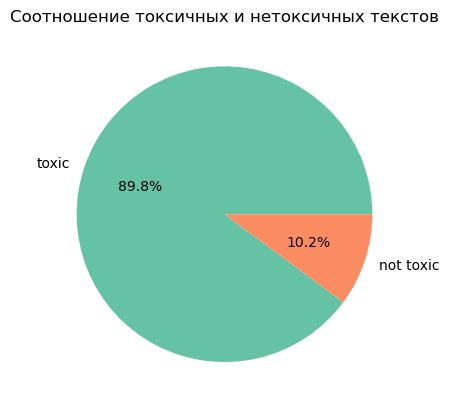

,count
toxic,
0,143106
1,16186


In [7]:
#соотношение токсичных и нетоксичных текстов
x=data.groupby('toxic')['toxic'].count()
labels = ['toxic', 'not toxic']
plt.title('Соотношение токсичных и нетоксичных текстов')
plt.pie(x=x, labels=labels, autopct='%1.1f%%', colors=plt.cm.Set2.colors)
plt.show()
del x
gc.collect()

display(pd.DataFrame(data.toxic.value_counts()))


<div class="alert"; style="border-left: 7px solid lightskyblue">

**Мини-вывод**
- Данные успешно загружены;
- В данных представленно `159292` уникальной записи (комментария);
- Пропуски `отсутствуют`;
- Токсичных комментариев - `~10%` (16186 шт.), не токсичных - `~90%` (143106 шт.) - сильный `дисбаланс`.
</div>

## Подготовка данных к обучению <a id='3'> </a>

Возможным шагом можно было бы считать андерсэмплинг или апсэмплинг данных, однако в данной работе не целесообразно прибегать к этим инструментам, так как можно исказить результаты работы модели, которая на реальных данных покажет себя плохо.

In [8]:
#очистим текст
def clean_text(text):
    return " ".join(re.sub(r'[^a-zA-Z]', ' ', text.lower()).split())

data['cleaned_text'] = data['text'].apply(clean_text)
data.head()

,text,toxic,cleaned_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


In [9]:
#напишем функцию, которая лемматизирует текст, используя spaCy лематтизацию
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatize_text(df):
    lemmatized_text_list = []
    for doc in tqdm(nlp.pipe(df)):
        lemmatized_text_list.append(' '.join(token.lemma_ for token in doc))
    return lemmatized_text_list

In [10]:
#проверим функцию тестовом df
sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns = ['text'])
df_my['text_l'] = lemmatize_text(df_my['text'])
display(df_my)
del df_my

2it [00:00, 171.48it/s]


,text,text_l
0,The striped bats are hanging on their feet for...,the stripe bat be hang on their foot for good
1,you should be ashamed of yourself went worked,you should be ashamed of yourself go work


In [11]:
#уберем ненужный столбец
data = data.drop(['text'], axis=1)

In [12]:
#упорядочим столбцы
data = data[['cleaned_text', 'toxic']]
data.head()

,cleaned_text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m se...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0


In [13]:
# закодированный процесс лемматизации
# затраченное время: 12:22 (214.66it/s)

#data['lemmatized_text'] = lemmatize_text(data['cleaned_text'])

In [14]:
#data_lemmatized = data[['lemmatized_text', 'toxic']]

In [15]:
# закодированные сохранение лемматизированных данных
#data_lemmatized.to_csv('data_lemmatized.csv')

In [16]:
del data
gc.collect();

In [17]:
#перезаписываем в data лемматизированные данные
data = csv_reader('data_lemmatized.csv')
data.sample(5)

,lemmatized_text,toxic
40273,I think it be relevant see propagandist no mor...,0
20670,you can t warning you moron now leave the page...,1
44299,use wikipedia guideline to back up wikipedia g...,0
17811,your edit to wwe backlash thank you for experi...,0
139762,I m not sure I agree with that bit of crystal ...,0


In [18]:
#удалим нулевые значения
data = data.dropna(subset='lemmatized_text')
data.isna().sum()

lemmatized_text    0
toxic              0
dtype: int64

Проведём частотный анализ текстов (облако слов), чтобы получить общее представление о тематике и о наиболее часто встречаемых словах в токсичных и нетоксичных твитах:

In [19]:
#скачаем английские стоп-слова
english_stopwords = stopwords.words('english') + ['u']

In [20]:
#токенизируем текст
data['tokenized_text'] = data['lemmatized_text'].apply(word_tokenize)

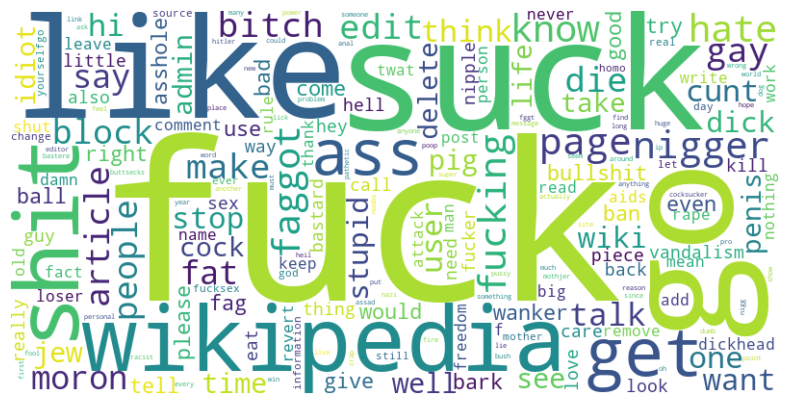

In [21]:
#популярные слова в токсичных комментариях
all_words_toxiс = [word for sublist in data[data['toxic'] == 1]['tokenized_text'] for word in sublist if word.lower() not in english_stopwords]

freq_dist_toxiс = FreqDist(all_words_toxiс)

words_freq_toxic = freq_dist_toxiс.items()

wordcloud = WordCloud(width=800, height=400, background_color='white')

wordcloud.generate_from_frequencies(dict(words_freq_toxic))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

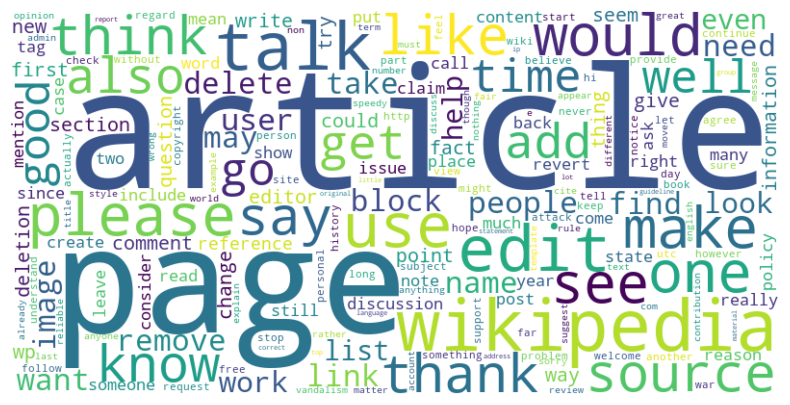

In [22]:
#популярные слова в нетоксичных комментариях
all_words_not_toxiс = [word for sublist in data[data['toxic'] != 1]['tokenized_text'] for word in sublist if word.lower() not in english_stopwords]

freq_dist_not_toxiс = FreqDist(all_words_not_toxiс)

words_freq_not_toxic = freq_dist_not_toxiс.items()

wordcloud = WordCloud(width=800, height=400, background_color='white')

wordcloud.generate_from_frequencies(dict(words_freq_not_toxic))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Как видим в токсичных комментариях много матных слов, в нетоксичные в основном нейтральные либо вежливые слова.

In [23]:
#удалим из памяти лишние переменные
del all_words_not_toxiс, all_words_toxiс, words_freq_not_toxic, words_freq_toxic
data.drop(columns=['tokenized_text'], axis=1, inplace=True)
gc.collect();

In [24]:
#создадим обучащющие и тестовые выборки
X = data['lemmatized_text']
y = data['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state = 42)

<div class="alert"; style="border-left: 7px solid lightskyblue">

**Мини-вывод по подготовке данных для обучения**
- тексты `очищены` от лишних символов;
- тексты `лемматизированы`;
- создаданы `обучающие` и `тестовые` выборки;
</div>

## Обучение модели <a id='4'> </a>

### LogisticRegression

In [25]:
RANDOM_STATE = 42

params_lr = {
    'tfvect__min_df': [10, 25],
    'tfvect__ngram_range': [(1, 4)],
    'model__C': [.5, 1, 5, 10],
    'model__penalty': ['l2']
}
pipeline_lr = Pipeline([
    ('tfvect', TfidfVectorizer(stop_words = english_stopwords)),
    ('model', LogisticRegression(random_state=RANDOM_STATE))])

grid_lr = GridSearchCV(pipeline_lr, cv=5, n_jobs=-1, param_grid=params_lr ,scoring='f1')

In [26]:
start_time = time.time()
grid_lr.fit(X_train, y_train)
end_time = time.time()
print('Время обучения модели LogisticRegression:', round(end_time - start_time, 2), 'seconds')

Время обучения модели LogisticRegression: 244.62 seconds


In [27]:
print("Лучшие параметры:", grid_lr.best_params_)
print("Лучшее значение F1:", grid_lr.best_score_)

Лучшие параметры: {'model__C': 10, 'model__penalty': 'l2', 'tfvect__min_df': 25, 'tfvect__ngram_range': (1, 4)}
Лучшее значение F1: 0.7720703232440445


### PassiveAggressiveClassifier

In [28]:
params_pac = {
    'tfvect__min_df': [10, 25, 30],
    'tfvect__ngram_range': [(1, 4)],
    'model__C': [.01, .05, .1, .5],
    'model__loss': ['hinge', 'squared_hinge'],
}

pipeline_pac = Pipeline([
    ('tfvect', TfidfVectorizer(stop_words=english_stopwords)),
    ('model', PassiveAggressiveClassifier(random_state=RANDOM_STATE))
])

grid_pac = GridSearchCV(pipeline_pac, cv=5, n_jobs=-1, param_grid=params_pac, scoring='f1')

In [29]:
start_time = time.time()
grid_pac.fit(X_train, y_train)
end_time = time.time()
print('Время обучения модели PassiveAggressiveClassifier:', round(end_time - start_time, 2), 'seconds')

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Время обучения модели PassiveAggressiveClassifier: 470.38 seconds


In [30]:
print("Лучшие параметры:", grid_pac.best_params_)
print("Лучшее значение F1:", grid_pac.best_score_)

Лучшие параметры: {'model__C': 0.05, 'model__loss': 'hinge', 'tfvect__min_df': 10, 'tfvect__ngram_range': (1, 4)}
Лучшее значение F1: 0.7841193982214983


### LGBMClassifier

In [31]:
params_lgbm = {
    'tfvect__min_df': [10, 30, 50, 100],
    'tfvect__ngram_range': [(1, 4)],
    'model__learning_rate': [0.01, 0.05],
    'model__n_estimators': [25, 50, 100],
    'model__num_leaves': [15, 25, 50],
    'model__class_weight': ['balanced']
}

pipeline_lgbm = Pipeline([
    ('tfvect', TfidfVectorizer(stop_words=english_stopwords)),
    ('model', LGBMClassifier(random_state=RANDOM_STATE, force_row_wise=True))
])

grid_lgbm = GridSearchCV(pipeline_lgbm, cv=5, n_jobs=-1, param_grid=params_lgbm, scoring='f1')

In [32]:
data_sample = data.sample(20000).reset_index(drop=True) #вынужден тут взять случайные 20000, иначе у меня умирает ядро

X1 = data_sample['lemmatized_text']
y1 = data_sample['toxic']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.25, stratify=y1, random_state = 42)

In [33]:
start_time = time.time()
grid_lgbm.fit(X_train1, y_train1)
end_time = time.time()
print('Время обучения модели LGBMClassifier:', round(end_time - start_time, 2), 'seconds')

[LightGBM] [Info] Number of positive: 1572, number of negative: 13428
[LightGBM] [Info] Total Bins 117960
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 4024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Время обучения модели LGBMClassifier: 226.46 seconds


In [34]:
print("Лучшие параметры:", grid_lgbm.best_params_)
print("Лучшее значение F1:", grid_lgbm.best_score_)

Лучшие параметры: {'model__class_weight': 'balanced', 'model__learning_rate': 0.05, 'model__n_estimators': 100, 'model__num_leaves': 15, 'tfvect__min_df': 10, 'tfvect__ngram_range': (1, 4)}
Лучшее значение F1: 0.6946606360602859


### Тестирование лучшей модели

In [35]:
y_preds = grid_pac.predict(X_test)

print('f1_score:', round(f1_score(y_test, y_preds), 2))

f1_score: 0.79
[LightGBM] [Info] Number of positive: 1258, number of negative: 10742
[LightGBM] [Info] Total Bins 82487
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 2181
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1258, number of negative: 10742
[LightGBM] [Info] Total Bins 69240
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 1232
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1257, number of negative: 10743
[LightGBM] [Info] Total Bins 91598
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 3221
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from sco

Значением метрики качества F1 = `0.79`. Это больше `0.75`, следовательно модель качественна и подходит заказчику.

Значением метрики качества F1 < `0.75`, следовательно модель предсзкаывает `некачественно`.

<div class="alert"; style="border-left: 7px solid lightskyblue">

**Мини-вывод по подготовке данных для обучения**
- был разработаны `пайплайны`, которые переводят данные в вектора для обучения и инциируют соответствующие модели машинного обучения;
- было обучено `три модели` для пресказания тональности текста: `LogisticRegression`, `PassiveAggressiveClassifier` и `LGBMClassifier`;
- лучшая модель `PassiveAggressiveClassifier`:
    - результат f1-score при кросс-валидации - `0.78`;
    - результат f1-score на тестовой выборке - `0.79`.
</div>

## Вывод <a id='5'> </a>

В рамках настоящего исследования была проведена работа с текстами комменатриев к описаниям товаров интернет-магазина «Викишоп» *с целью обучения модели, которая будет классифицировать комментарии на позитивные и негативные со значением метрики качества F1 не меньше 0.75*

**В результате изучения и предобработки были определено**:
- В данных представленно `159292` уникальной записи (комментария);
- Пропуски `отсутствуют`;
- Токсичных комментариев - `~10%` (16186 шт.), не токсичных - `~90%` (143106 шт.) - сильный `дисбаланс`.

**В результате подготовки данных к обучению**:
- был разработаны `пайплайны`, которые переводят данные в вектора для обучения и инциируют соответствующие модели машинного обучения.
**В рамках обучения модели**:
- было обучено `три модели` для пресказания тональности текста: `LogisticRegression`, `PassiveAggressiveClassifier` и `LGBMClassifier`;
- лучшая модель `PassiveAggressiveClassifier`:
    - результат f1-score при кросс-валидации - `0.78`;
    - результат f1-score на тестовой выборке - `0.79`.